In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs

import sys
sys.path.insert(1, '/kaggle/input/quadrule')

from GaussJacobiQuadRule_V3 import Jacobi, DJacobi, GaussLobattoJacobiWeights, GaussJacobiWeights
import time
import os


#notes:
#remove all persistent==true can slow down the code
#maybe is not the best use to save in memory all the traslated elem elements,just save all the test fuction and the derivatives of the test functions
#two different inits,implemented
#maybe use diff quad rules,for istance quadpy
#


2023-09-28 08:04:48.392428: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-28 08:04:48.419093: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-28 08:04:48.624493: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-28 08:04:48.626163: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 08:04:49.643139: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
class VPINN(tf.keras.Model):

    def __init__(self, pb, params,seed,NN):

        super().__init__()

        # accept parameters
        self.pb = pb
        self.params = params
        self.SEED=seed

        # generate all precomp stuff
        self.generate_boundary_points()
        self.generate_inner_points()
        self.generate_quadrature_points()
        self.construct_RHS()

        # add the neural network to the class if given at initialisation
        if NN:
            self.set_NN(NN)
        else: 
            self.NN=self.initialize_NN()
            self.vars = self.NN.trainable_variables
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.params['LR'])

    def set_NN(self, NN, LR):
        np.random.seed(self.SEED)
        tf.random.set_seed(self.SEED)
        # initialise the NN
        self.NN = NN

        # take trainable vars
        self.vars = self.NN.trainable_variables

        # set optimiser
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

    def initialize_NN(self):

        NN = tf.keras.Sequential()
        NN.add(tf.keras.layers.InputLayer(self.params['NN_struct'][0],dtype=tf.float64))
        # NN.add(tf.keras.layers.Lambda(lambda x: 2. * (x + 1) / (2) - 1.))

        for width in self.params['NN_struct'][1:-1]:
            NN.add(tf.keras.layers.Dense(width,
                                            activation=tf.math.sin,
                                            use_bias=True,
                                            kernel_initializer=tf.keras.initializers.GlorotUniform(self.SEED),
                                            bias_initializer='zeros',dtype=tf.float64))
        NN.add(tf.keras.layers.Dense(self.params['NN_struct'][-1], activation='linear',dtype=tf.float64,kernel_initializer=tf.keras.initializers.GlorotUniform(self.SEED)))

        return NN


    def eval_NN(self, x):
        x = tf.convert_to_tensor(x, dtype=tf.float64)        

        with tf.GradientTape() as second_order:
            second_order.watch(x)
            with tf.GradientTape() as first_order:
                first_order.watch(x)
                u = self.NN(x)
            d1xu = first_order.gradient(u, x)
        d2xu = second_order.gradient(d1xu, x)

        del first_order
        del second_order

        return u, d1xu, d2xu

    def boundary_loss(self):
    ## NOTE:impose boundary or same structure for ICs
        u_bound_NN = self.eval_NN(self.boundary_points)[0]
        return tf.reduce_mean(tf.square(u_bound_NN - self.boundary_sol))

    def variational_loss(self):
        #TODO: general organisation
        varloss_total = 0.0
        N = self.params['n_elements']
        for el in range(N):
                
            n_test = self.params['n_test'][el]

            F_ext_element = self.F_ext_total[el]
            jacobian = self.J[el]
            x_quad_element = self.x_quad_total[el]
            v_quad_element = self.v_quad_total[el]
            dv_quad_element = self.dv_quad_total[el]
            dv_boundary_element = self.dv_boundary_total[el]
            d2v_quad_element = self.d2v_quad_total[el]


            u_NN_quad_el, d1xu_NN_quad_el, d2xu_NN_quad_el = self.eval_NN(x_quad_element)
            # dv_boundary_element, _ = self.pb.dtest_func(n_test, np.array([-1, 1]))

            if self.params['var_form'] == 0:
                u_NN_el = tf.stack([-jacobian*tf.reduce_sum(self.w_quad*d2xu_NN_quad_el*v_quad_element[i]) \
                                    for i in range(n_test)])

            elif self.params['var_form'] == 1:
                u_NN_el = tf.stack([jacobian*tf.reduce_sum(self.w_quad*d1xu_NN_quad_el*dv_quad_element[i]) \
                                    for i in range(n_test)])   #it seems it this way that the test functions of the elem are scaled by the the half of the interval size,so when they are sclaed by the jacobian it cancels
                

            elif self.params['var_form'] == 2:
                u_NN_bound_el, _, _  = self.eval_NN(np.array([x_quad_element[0], x_quad_element[-1]]))
                u_NN_el = tf.stack([-1/jacobian*tf.reduce_sum(self.w_quad*u_NN_quad_el*d2v_quad_element[i]) \
                                    +1/jacobian*tf.reduce_sum(u_NN_bound_el*np.array([-dv_boundary_element[i][0], dv_boundary_element[i][-1]]))  \
                                    for i in range(n_test)])
            

            res_NN_element = u_NN_el - F_ext_element
            loss_element = tf.reduce_mean(tf.square(res_NN_element))
            varloss_total = varloss_total + loss_element


        return varloss_total

    @tf.function
    def loss_total(self):
        loss_0 = 0.0
        loss_b = self.boundary_loss()
        loss_v = self.variational_loss()
        loss_tot = loss_0 + loss_b + loss_v
        return loss_tot, loss_b, loss_v

    def loss_gradient(self):
        with tf.GradientTape() as loss_grad:
            #TODO: why is this commented?
            # loss_grad.watch(self.vars)
            loss_tot, loss_b, loss_v = self.loss_total()
        gradient = loss_grad.gradient(loss_tot, self.vars)
        return loss_tot, loss_b, loss_v, gradient

    @tf.function
    def gradient_descent(self):
        loss_tot, loss_b, loss_v, gradient = self.loss_gradient()
        self.optimizer.apply_gradients(zip(gradient, self.vars))
        return loss_tot, loss_b, loss_v

    def train(self, opt_iter):

        history = []

        start_time = time.time()
        for i in range(opt_iter):

            loss_tot, loss_b, loss_v = self.gradient_descent()

            if i % 10 == 0:
                history.append([i, loss_tot, loss_b, loss_v])


            if i % 100 == 0:
                elapsed = time.time() - start_time
                str_print = 'It: %d, Lossb: %.3e, Lossv: %.3e, Losstot:, %.3e, Time: %.2f'
                print(str_print % (i, loss_b, loss_v, loss_tot, elapsed))
                start_time = time.time()

        history = np.array(history)
        self.iterations = history[:,0]
        self.loss_tot = history[:,1]
        self.loss_b = history[:,2]
        self.loss_v = history[:,3]

        return self.loss_tot

    def get_domain_info(self):

        a = self.params['domain'][0]
        b = self.params['domain'][1]

        scale = b - a
        mid = (a + b)*0.5

        return a, b, scale, mid

    def generate_boundary_points(self):
        # Boundary points
        a, b, scale, mid = self.get_domain_info()

        self.boundary_points = np.asarray([a,b], dtype=np.float64)[:,None]
        self.boundary_sol = self.pb.u_exact(self.boundary_points)


    def generate_inner_points(self):
        _, _, scale, mid = self.get_domain_info()

        self.X_f_train = np.array(scale*(lhs(1, self.params['n_bound']) - 0.5) + mid).flatten()
        self.f_train = np.asarray(self.pb.f_exact(self.X_f_train))
        # self.f_train = ff[:, None]

    def generate_quadrature_points(self):
        [self.x_quad, self.w_quad] = GaussLobattoJacobiWeights(self.params['n_quad'], 0, 0)



    def construct_RHS(self):
        #TODO: check are the convert to tensors are needed
        N = self.params['n_elements']
        lower_bound, upper_bound, _, _ = self.get_domain_info()
        dx = (upper_bound - lower_bound)/N
        self.grid_x = np.asarray([lower_bound + i*dx for i in range(N+1)])
        n_test_funcs = self.params['n_test']

        self.U_ext_total = []
        self.F_ext_total = []
        self.J = []
        self.x_quad_total = []
        self.v_quad_total = []
        self.dv_quad_total = []
        self.dv_boundary_total = []
        self.d2v_quad_total = []

        for el_x in range(N):
            Ntest_element = n_test_funcs[el_x]

            a = self.grid_x[el_x]
            b = self.grid_x[el_x+1]

            jacobian = (b - a)/2
            x_quad_element = a + jacobian*(self.x_quad+1)

            v_quad_element = self.pb.test_func(Ntest_element, self.x_quad)        
            dv_quad_element, d2v_quad_element = self.pb.dtest_func(Ntest_element, self.x_quad)
            dv_boundary_element, _ = self.pb.dtest_func(Ntest_element, np.array([a, b]))

            u_quad_element = self.pb.u_exact(x_quad_element)
            f_quad_element = self.pb.f_exact(x_quad_element)

            U_ext_element = np.asarray([jacobian*np.sum(self.w_quad*v_quad_element[r]*u_quad_element)
                for r in range(Ntest_element)])

            F_ext_element = np.asarray([jacobian*np.sum(self.w_quad*v_quad_element[r]*f_quad_element)
                for r in range(Ntest_element)])


            self.U_ext_total.append(U_ext_element)
            self.F_ext_total.append(F_ext_element)
            self.J.append(jacobian)
            self.x_quad_total.append(x_quad_element)
            self.v_quad_total.append(v_quad_element)
            self.dv_quad_total.append(dv_quad_element)
            self.dv_boundary_total.append(dv_boundary_element)
            self.d2v_quad_total.append(d2v_quad_element)

            
        self.F_ext_total = tf.convert_to_tensor(self.F_ext_total, tf.float64)

    def generate_test_points(self):
        lower_bound, upper_bound, _, _ = self.get_domain_info()

        delta_test = self.params['delta_test']
        x_test = np.arange(lower_bound, upper_bound + delta_test, delta_test)
        data_temp = np.asarray([[x_test[i], self.pb.u_exact(x_test[i])]
                                 for i in range(len(x_test))])
    
        x_test = data_temp.flatten()[0::2]
        exact = data_temp.flatten()[1::2]
        return x_test[:, None], exact[:, None], len(x_test)
    

    def plot_loss_history(self, PLOT='SHOW'):

        font = 24
        fig, ax = plt.subplots()
        plt.tick_params(axis='y', which='both', labelleft='on', labelright='off') 
        plt.xlabel('$iteration$', fontsize = font)
        plt.ylabel('$loss \,\, values$', fontsize = font)
        plt.yscale('log')
        plt.grid(True)
        plt.plot(self.iterations, self.loss_tot,'green',label="loss")
        plt.legend(loc="upper right")
        plt.tick_params( labelsize = 20)
        fig.set_size_inches(w=11,h=5.5)
        plt.show()
        
        fig, ax = plt.subplots()
        plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
        plt.xlabel('$iteration$', fontsize = font)
        plt.ylabel('$loss \,\, values$', fontsize = font)
        plt.yscale('log')
        plt.grid(True)
        plt.plot(self.iterations, self.loss_tot,'green',label="loss")
        plt.plot(self.iterations, self.loss_b,'blue',label="boundary_loss")
        plt.plot(self.iterations, self.loss_v, 'violet',label="variational_loss")
        plt.legend(loc="upper right")
        plt.tick_params( labelsize = 20)
        fig.set_size_inches(w=11,h=5.5)
        plt.show()

        if PLOT == 'save':
            plt.savefig('VPINN_loss_history.pdf')
        else:
            plt.show()
        

    def plot_predict(self, PLOT='SHOW'):

        x, sol, n_points = self.generate_test_points()
        prediction = self.eval_NN(x)[0]
        
        pnt_skip = 25
        fig, ax = plt.subplots()
        plt.locator_params(axis='x', nbins=6)
        plt.locator_params(axis='y', nbins=8)

        plt.xlabel('$x$', fontsize = 24)
        plt.ylabel('$u$', fontsize = 24)
        plt.axhline(0, linewidth=0.8, linestyle='-', color='gray')
        for xc in self.grid_x:
            plt.axvline(x=xc, linewidth=2, ls = '--')
        plt.plot(x, sol, linewidth=1, color='r', label=''.join(['$exact$']))
        plt.plot(x, prediction, 'k*', label='$VPINN$')
        plt.tick_params( labelsize = 20)
        legend = plt.legend(shadow=True, loc='upper left', fontsize=18, ncol = 1)
        fig.set_size_inches(w=11,h=5.5)
        plt.show()

        if PLOT == 'save':
            plt.savefig('Exact.png')
        else:
            plt.show()
        
        
    def plot_pointwise_error(self, PLOT='SHOW'):

        x, sol, n_points = self.generate_test_points()

        prediction = self.eval_NN(x)[0]

        fig, ax = plt.subplots()
        plt.locator_params(axis='x', nbins=6)
        plt.locator_params(axis='y', nbins=8)
        plt.xlabel('$x$', fontsize = 24)
        plt.ylabel('point-wise error', fontsize = 24)
        plt.yscale('log')
        plt.axhline(0, linewidth=0.8, linestyle='-', color='gray')
        for xc in self.grid_x:
            plt.axvline(x=xc, linewidth=2, ls = '--')
        plt.plot(x, abs(sol - prediction), 'k')
        plt.tick_params( labelsize = 20)
        fig.set_size_inches(w=11,h=5.5)
        plt.show()

        if PLOT == 'save':
            plt.savefig('Pointwise_Error.png')
        else:
            plt.show()

In [3]:
class PROBDEF:

    def __init__(self, omega: tuple, r: int):
        self.omega = omega
        self.r = r

    def u_exact(self, x):
        utemp = 0.1*np.sin(self.omega*x) + np.tanh(self.r*x)
        return utemp

    def f_exact(self, x):
        A =  0.1*(self.omega**2)*np.sin(self.omega*x)
        B = (2*self.r**2)*(np.tanh(self.r*x))
        B /= (np.cosh(self.r*x)); B /= (np.cosh(self.r*x))
        return A + B

    @staticmethod
    def test_func_core(n, x):
        test = Jacobi(n+1, 0, 0, x) - Jacobi(n-1, 0, 0, x)
        return test

    def test_func(self, n_test, x):
        test_total = [self.test_func_core(n, x) for n in range(1, n_test+1)]
        return np.asarray(test_total)

    def dtest_func(self, n_test, x):
        n = 1
        d1test_total = [((n+2)/2)*Jacobi(n, 1, 1, x)]
        d2test_total = [((n+2)*(n+3)/(2*2))*Jacobi(n-1, 2, 2, x)]
        for n in range(2, n_test+1):
            if n == 2:
                d1test = ((n+2)/2)*Jacobi(n, 1, 1, x) - ((n)/2)*Jacobi(n-2, 1, 1, x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1, 2, 2, x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)
            elif n > 2:
                d1test = ((n+2)/2)*Jacobi(n, 1, 1, x) - ((n)/2)*Jacobi(n-2, 1, 1, x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1, 2, 2, x) - ((n)*(n+1)/(2*2))*Jacobi(n-3, 2, 2, x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)
            else:
                raise ValueError("Please check the value for 'n_test'")
        return np.asarray(d1test_total), np.asarray(d2test_total)
    
    
'''
Hyper-parameters: 
    scheme     = is either 'PINNs' or 'VPINNs'
    Net_layer  = the structure of fully connected network
    var_form   = the form of the variational formulation used in VPINNs
                    0, 1, 2: no, once, twice integration-by-parts
    N_el_x, N_el_y     = number of elements in x and y direction
    N_test_x, N_test_y = number of test functions in x and y direction
    N_quad     = number of quadrature points in each direction in each element
    N_bound    = number of boundary points in the boundary loss
    N_residual = number of residual points in PINNs
'''

"\nHyper-parameters: \n    scheme     = is either 'PINNs' or 'VPINNs'\n    Net_layer  = the structure of fully connected network\n    var_form   = the form of the variational formulation used in VPINNs\n                    0, 1, 2: no, once, twice integration-by-parts\n    N_el_x, N_el_y     = number of elements in x and y direction\n    N_test_x, N_test_y = number of test functions in x and y direction\n    N_quad     = number of quadrature points in each direction in each element\n    N_bound    = number of boundary points in the boundary loss\n    N_residual = number of residual points in PINNs\n"

In [4]:
pb = PROBDEF((8*np.pi), 80)
N_tests = 20
N_elements = 5
params = {'scheme': 'VPINNs',
            'NN_struct': [1] + [20] * 4 + [1],
            'var_form': 1,
            'n_elements': N_elements,
            'n_test': N_elements*[N_tests],
            'n_quad': 100,
            'n_bound': 50,
            'n_residual': 100,
            'domain': (-1, 1),
            'Opt_Niter': 2500 + 1,
            'delta_test': 0.01,
            'LR': 0.001}
print(params)

{'scheme': 'VPINNs', 'NN_struct': [1, 20, 20, 20, 20, 1], 'var_form': 1, 'n_elements': 5, 'n_test': [20, 20, 20, 20, 20], 'n_quad': 100, 'n_bound': 50, 'n_residual': 100, 'domain': (-1, 1), 'Opt_Niter': 2501, 'delta_test': 0.01, 'LR': 0.001}


/home/mariano/Documenti/test/base/lib/python3.9/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))


Number of elements :  5


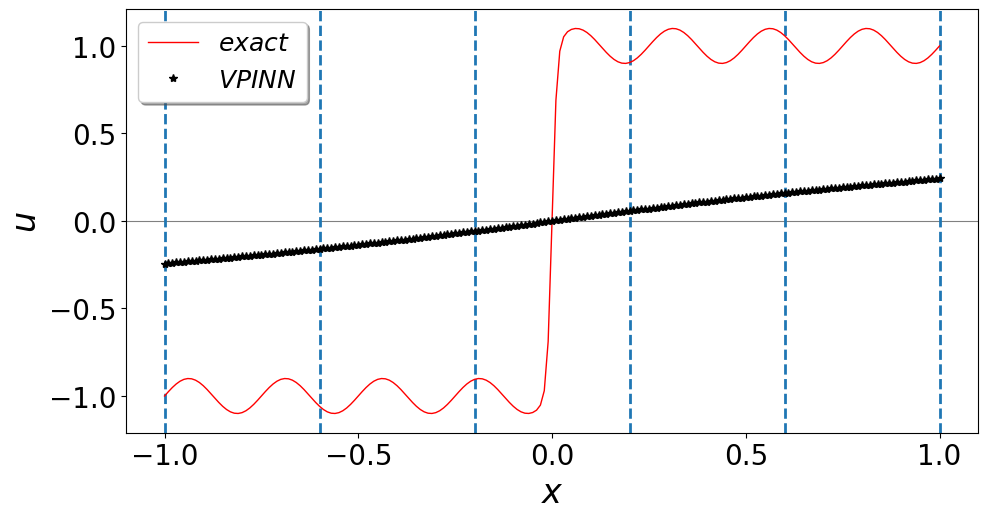

Iteration: 0 loss: 866.603558 time: 2.7175402641296387
Iteration: 10 loss: 866.007382 time: 0.013576269149780273
Iteration: 20 loss: 866.034089 time: 0.012064218521118164
Iteration: 30 loss: 865.975917 time: 0.012620687484741211
Iteration: 40 loss: 865.944363 time: 0.013488531112670898
Iteration: 50 loss: 865.844555 time: 0.014179706573486328
Iteration: 60 loss: 865.561640 time: 0.012445688247680664
Iteration: 70 loss: 864.594767 time: 0.012296438217163086
Iteration: 80 loss: 861.244570 time: 0.014100074768066406
Iteration: 90 loss: 851.450571 time: 0.014899969100952148
Iteration: 100 loss: 825.429244 time: 0.013297557830810547
Iteration: 110 loss: 763.825733 time: 0.01622629165649414
Iteration: 120 loss: 651.672652 time: 0.01773667335510254
Iteration: 130 loss: 498.427175 time: 0.013848304748535156
Iteration: 140 loss: 306.058234 time: 0.01381540298461914
Iteration: 150 loss: 122.269294 time: 0.011050224304199219
Iteration: 160 loss: 74.794413 time: 0.013196468353271484
Iteration: 170

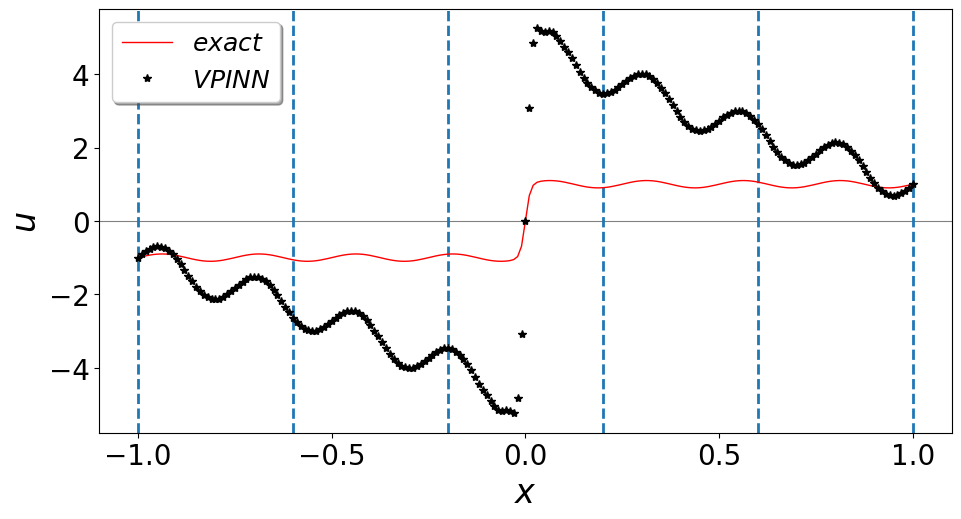

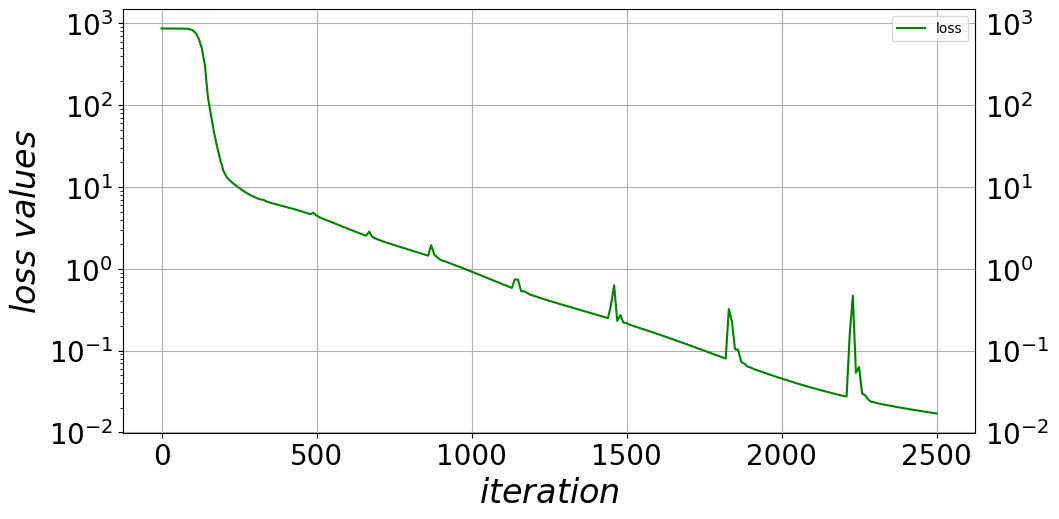

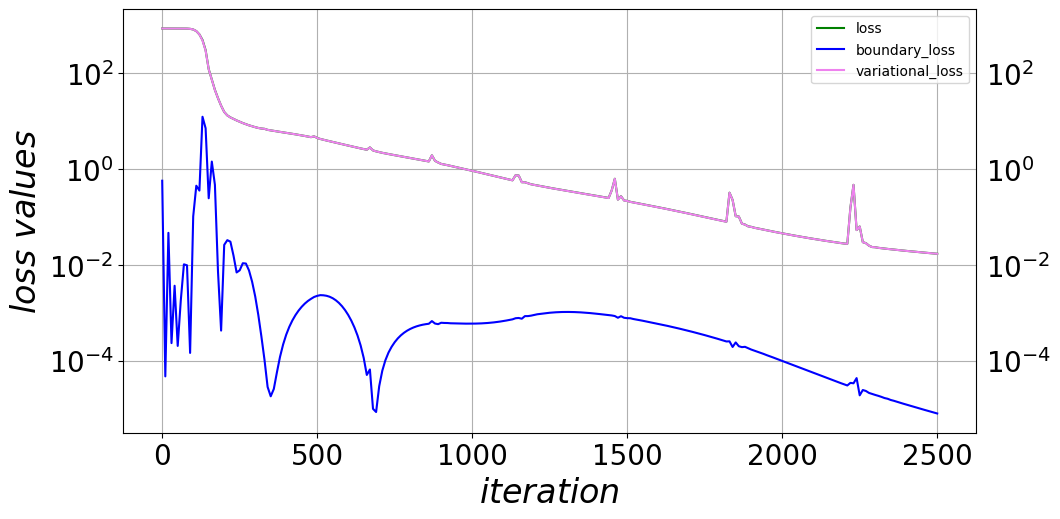

/tmp/ipykernel_4220/1024873400.py:336: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.axvline(x=xc, linewidth=2, ls = '--')


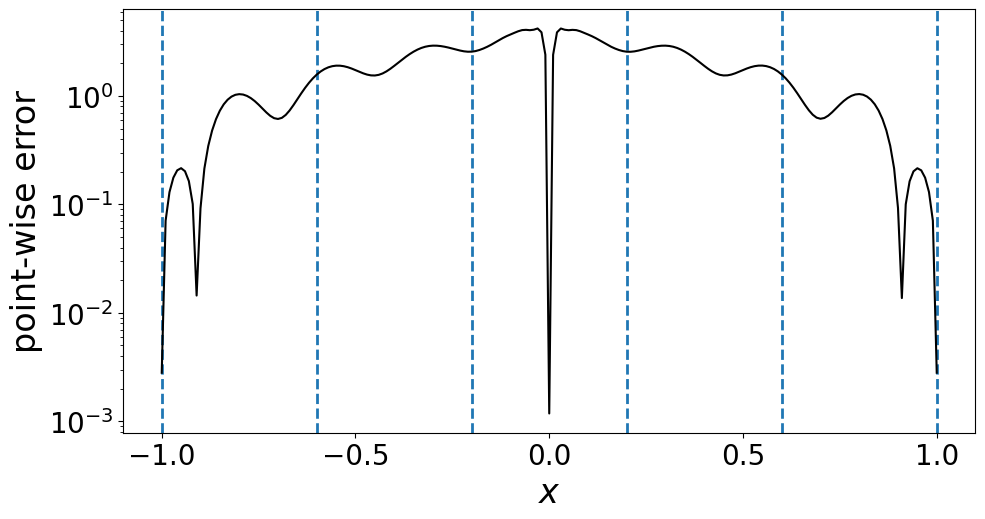

Number of elements :  10


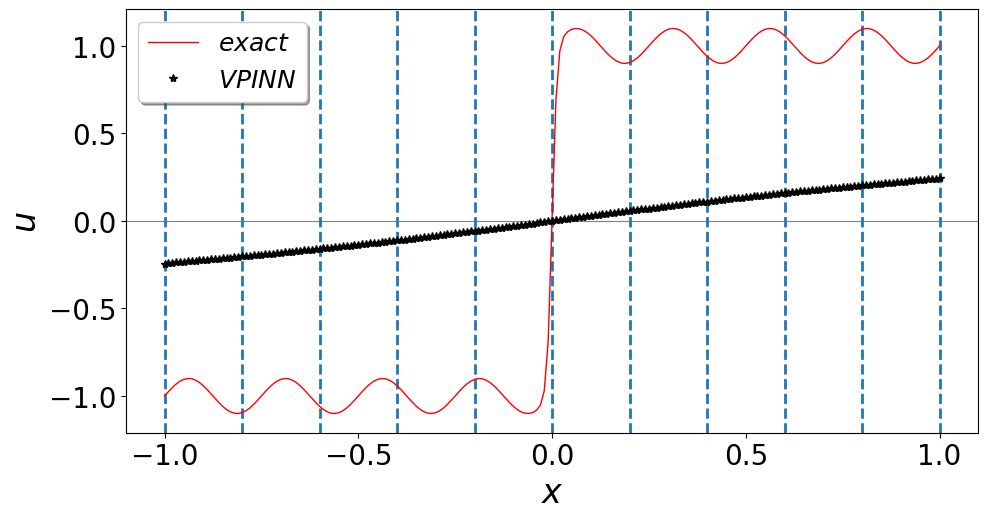

Iteration: 0 loss: 645.355421 time: 4.206833362579346
Iteration: 10 loss: 644.779681 time: 0.01975703239440918
Iteration: 20 loss: 644.813331 time: 0.01671123504638672
Iteration: 30 loss: 644.770460 time: 0.016900300979614258
Iteration: 40 loss: 644.766070 time: 0.01810169219970703
Iteration: 50 loss: 644.744405 time: 0.01793813705444336
Iteration: 60 loss: 644.706800 time: 0.017724037170410156
Iteration: 70 loss: 644.619415 time: 0.017852306365966797
Iteration: 80 loss: 644.381334 time: 0.016900062561035156
Iteration: 90 loss: 643.711462 time: 0.017485380172729492
Iteration: 100 loss: 641.798493 time: 0.01828908920288086
Iteration: 110 loss: 636.197691 time: 0.017687320709228516
Iteration: 120 loss: 620.884898 time: 0.01825261116027832
Iteration: 130 loss: 590.803872 time: 0.024003028869628906
Iteration: 140 loss: 547.139588 time: 0.021162986755371094
Iteration: 150 loss: 484.827048 time: 0.01897573471069336
Iteration: 160 loss: 402.280413 time: 0.019246816635131836
Iteration: 170 los

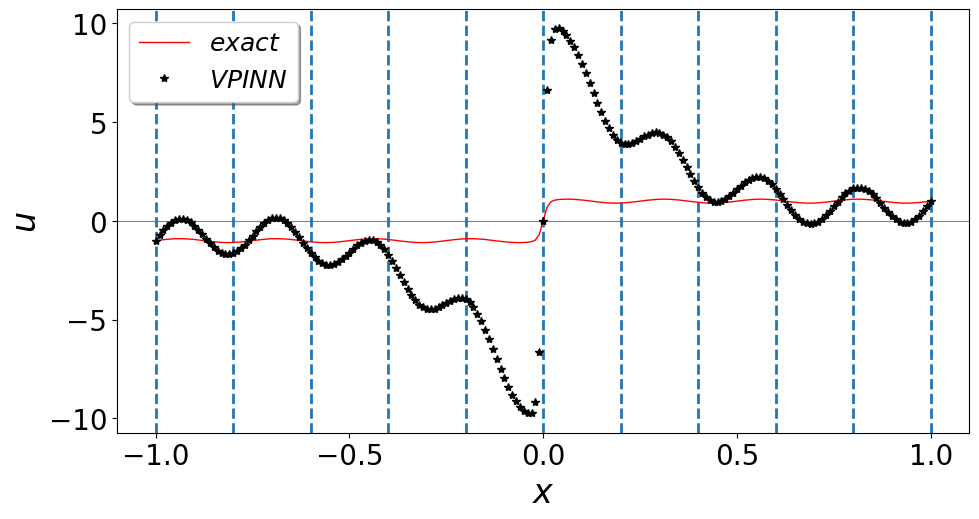

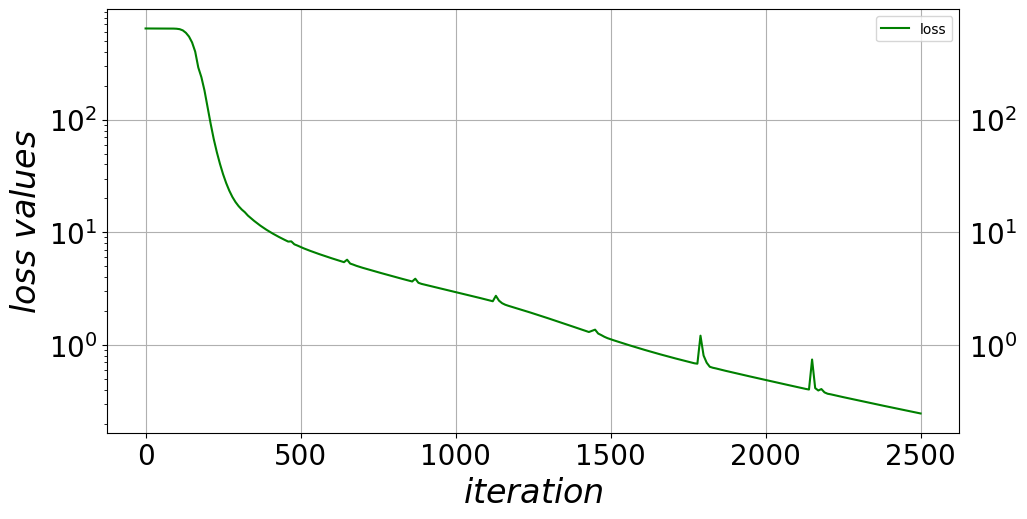

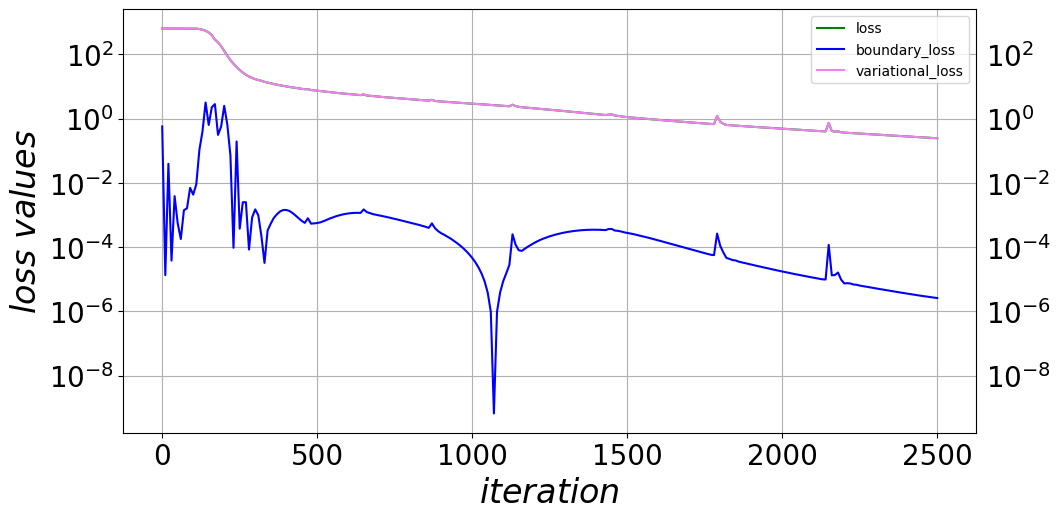

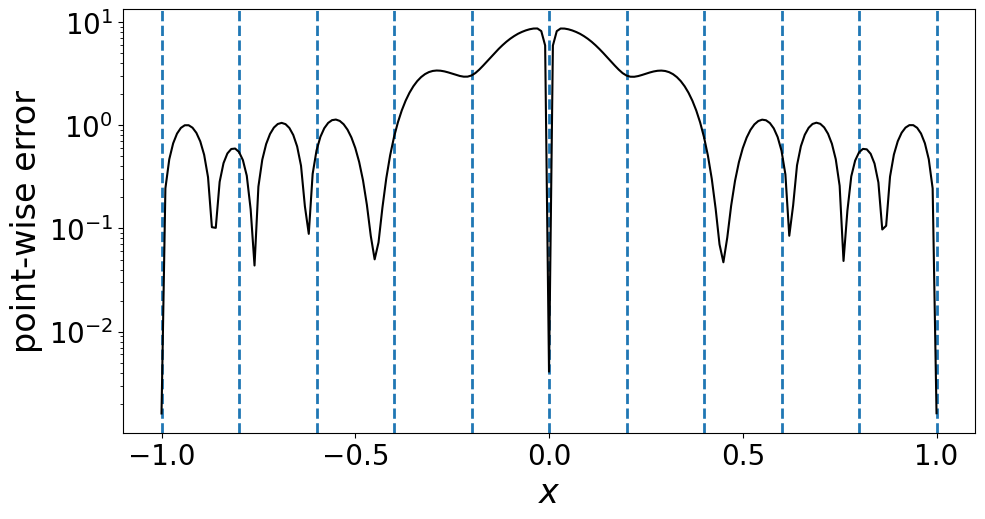

Number of elements :  20


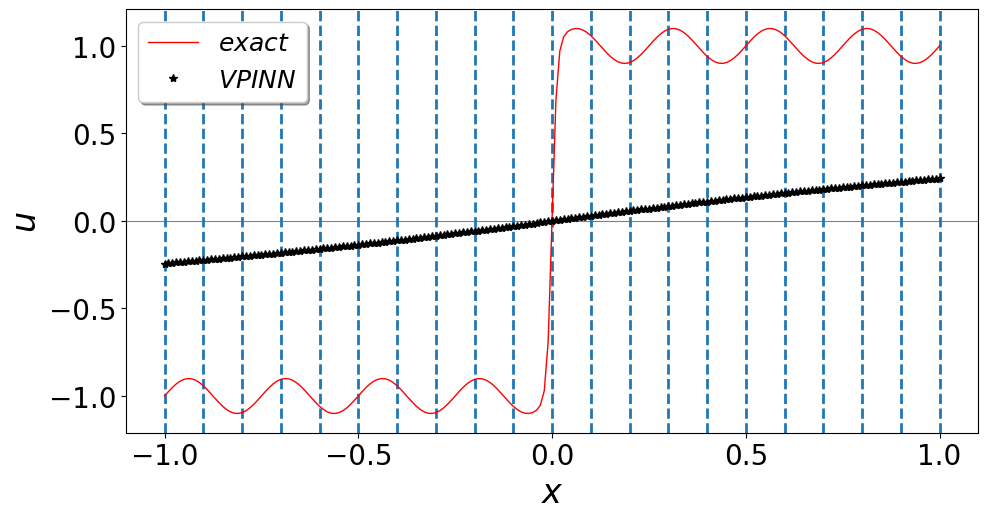

Iteration: 0 loss: 835.298558 time: 8.411554098129272
Iteration: 10 loss: 834.723953 time: 0.04039120674133301
Iteration: 20 loss: 834.761124 time: 0.036818742752075195
Iteration: 30 loss: 834.723762 time: 0.036486148834228516
Iteration: 40 loss: 834.727943 time: 0.03560781478881836
Iteration: 50 loss: 834.723321 time: 0.036849260330200195
Iteration: 60 loss: 834.723106 time: 0.03867316246032715
Iteration: 70 loss: 834.722459 time: 0.048215627670288086
Iteration: 80 loss: 834.721747 time: 0.04186296463012695
Iteration: 90 loss: 834.721081 time: 0.035384178161621094
Iteration: 100 loss: 834.720205 time: 0.03795814514160156
Iteration: 110 loss: 834.719090 time: 0.03597664833068848
Iteration: 120 loss: 834.717641 time: 0.03861379623413086
Iteration: 130 loss: 834.715703 time: 0.04452967643737793
Iteration: 140 loss: 834.713025 time: 0.045531511306762695
Iteration: 150 loss: 834.709182 time: 0.04568314552307129
Iteration: 160 loss: 834.703378 time: 0.03423953056335449
Iteration: 170 loss: 

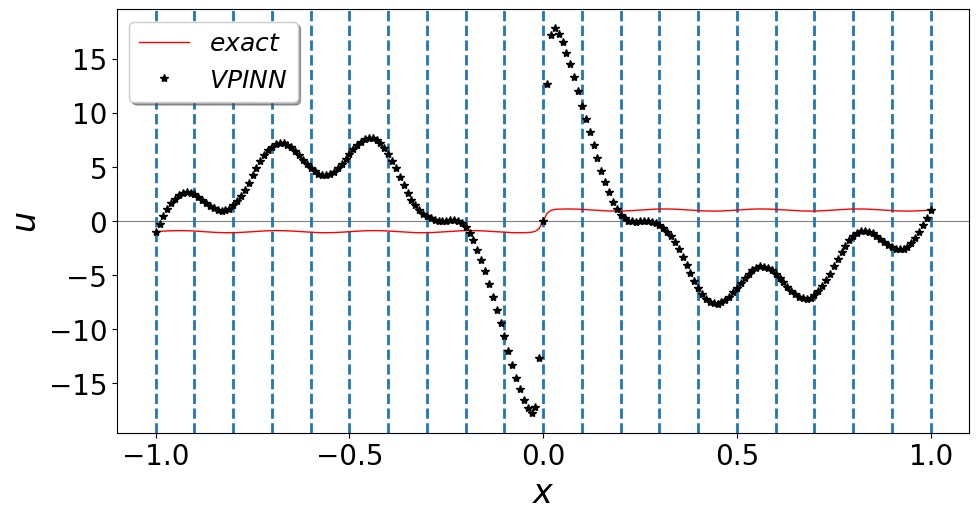

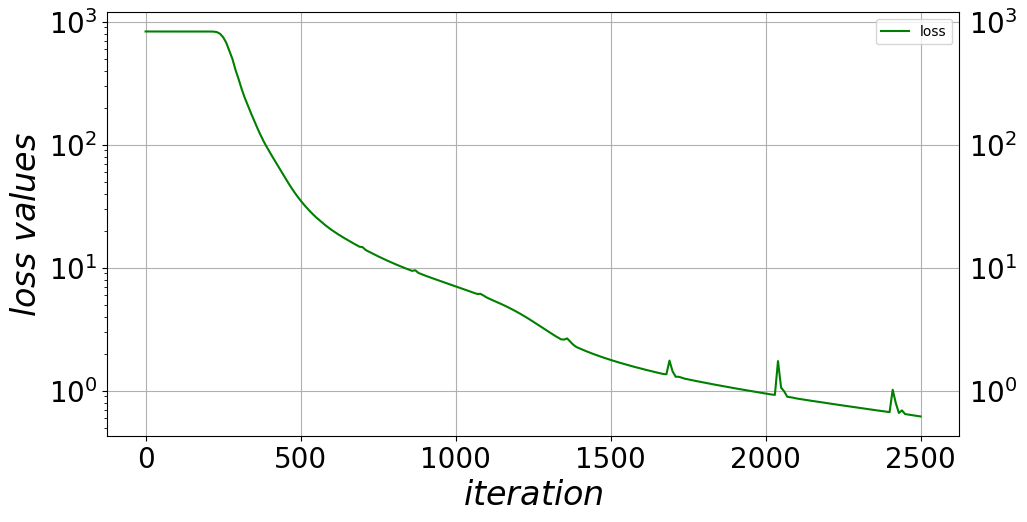

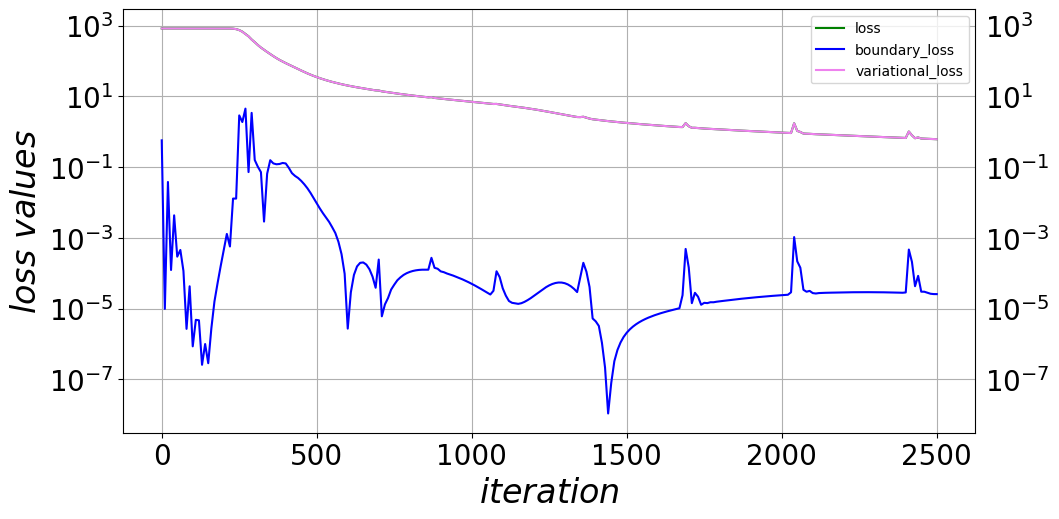

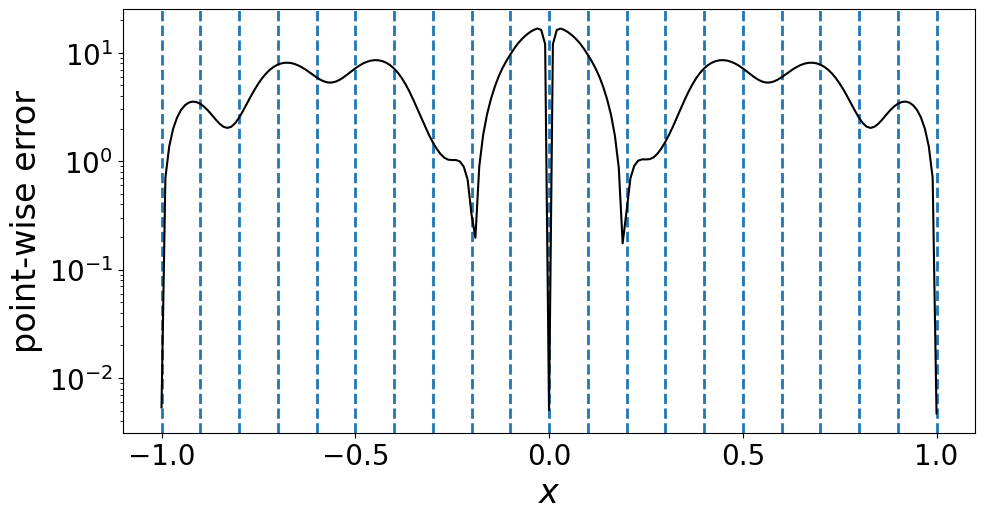

Number of elements :  40


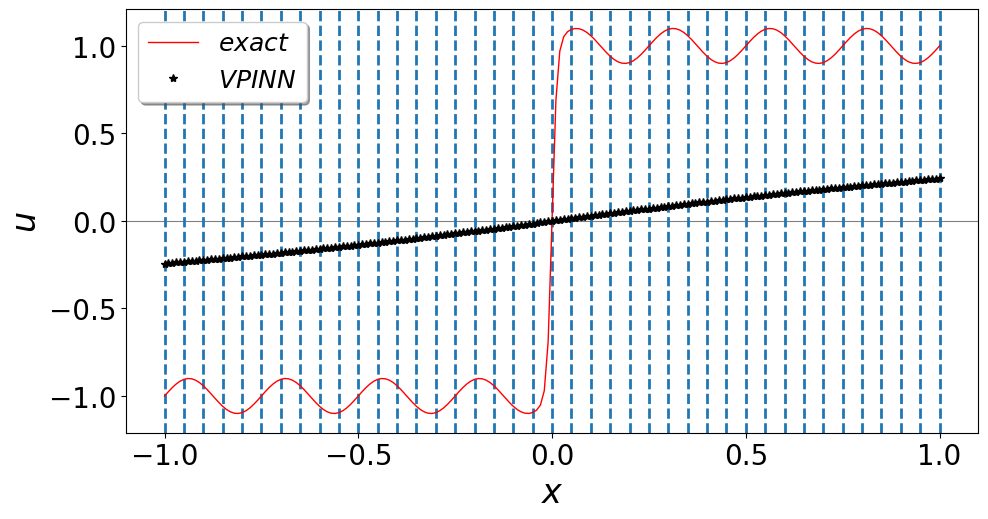

Iteration: 0 loss: 971.563084 time: 17.545379638671875
Iteration: 10 loss: 970.989793 time: 0.053385019302368164
Iteration: 20 loss: 971.026998 time: 0.057172536849975586
Iteration: 30 loss: 970.989942 time: 0.05340147018432617
Iteration: 40 loss: 970.994289 time: 0.054839372634887695
Iteration: 50 loss: 970.989965 time: 0.06726646423339844
Iteration: 60 loss: 970.990069 time: 0.05690145492553711
Iteration: 70 loss: 970.989868 time: 0.05358624458312988
Iteration: 80 loss: 970.989671 time: 0.05796957015991211
Iteration: 90 loss: 970.989665 time: 0.060190439224243164
Iteration: 100 loss: 970.989626 time: 0.057959556579589844
Iteration: 110 loss: 970.989588 time: 0.05507659912109375
Iteration: 120 loss: 970.989556 time: 0.05785012245178223
Iteration: 130 loss: 970.989520 time: 0.05908370018005371
Iteration: 140 loss: 970.989481 time: 0.05458831787109375
Iteration: 150 loss: 970.989438 time: 0.05641579627990723
Iteration: 160 loss: 970.989390 time: 0.05746030807495117
Iteration: 170 loss: 

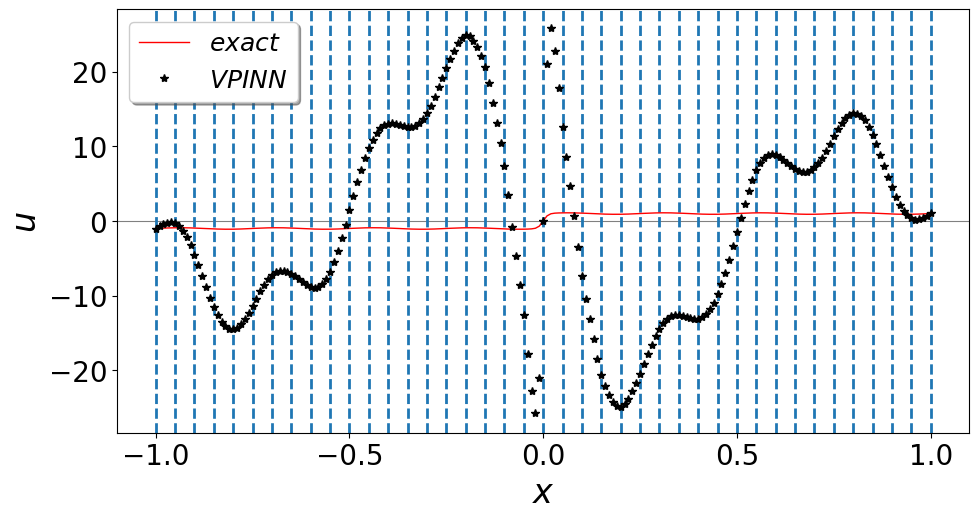

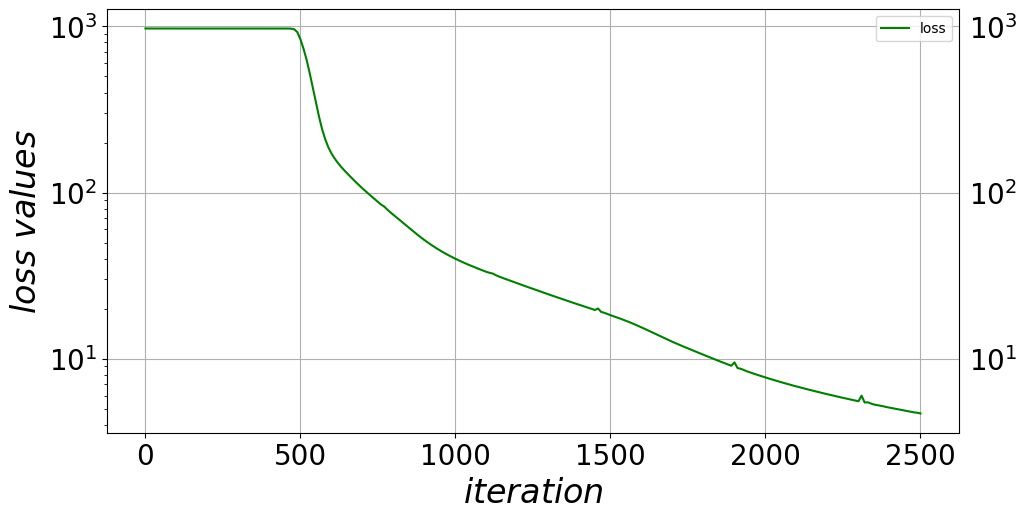

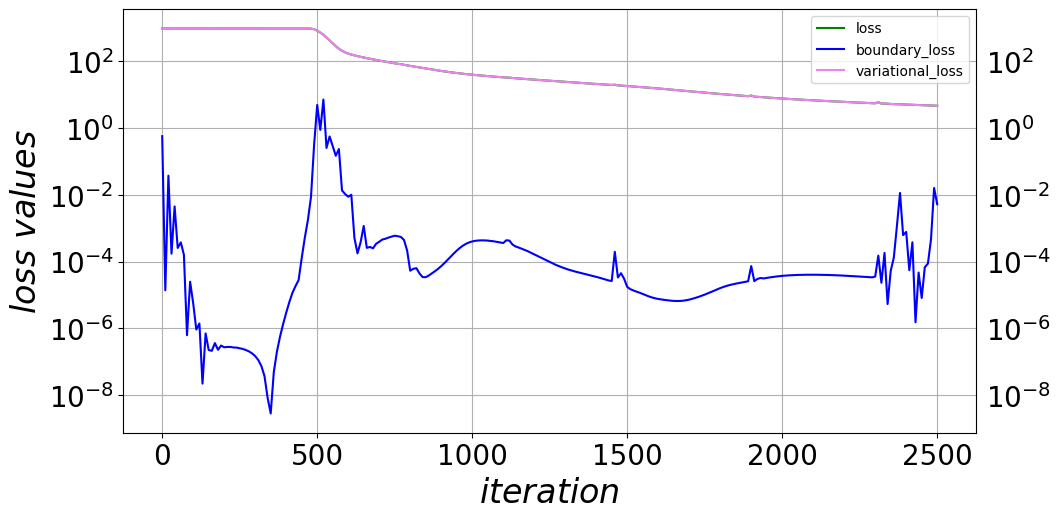

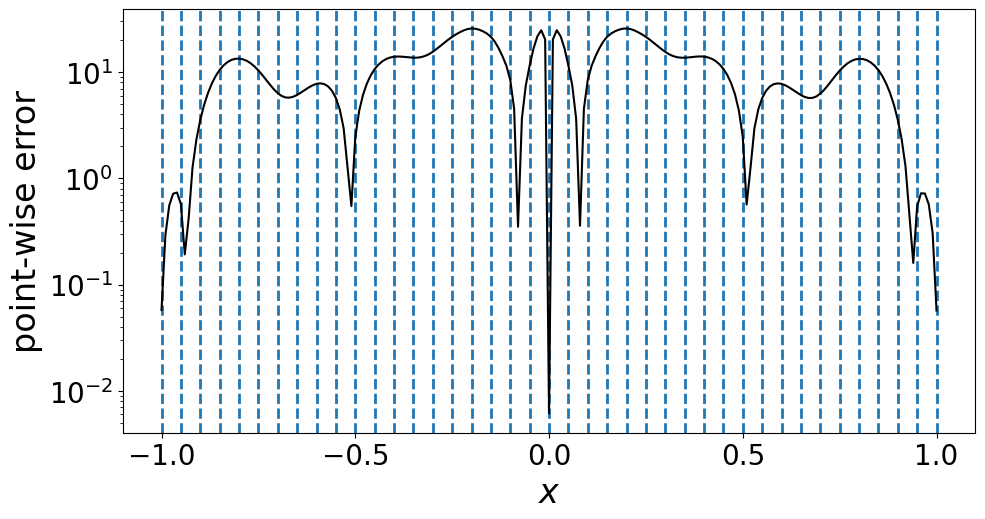

Number of elements :  80


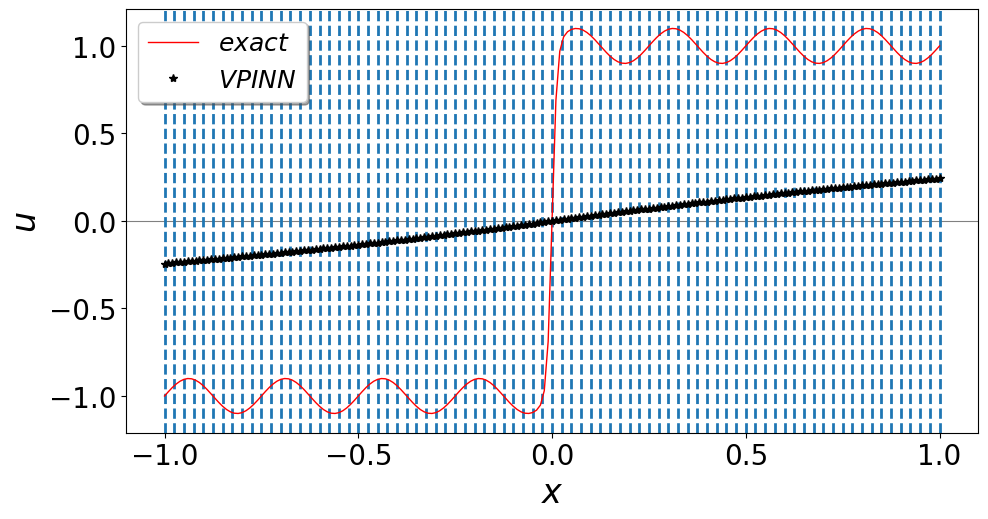

Iteration: 0 loss: 807.566051 time: 37.838682413101196
Iteration: 10 loss: 806.993154 time: 0.10744714736938477
Iteration: 20 loss: 807.030328 time: 0.13756513595581055
Iteration: 30 loss: 806.993328 time: 0.13553881645202637
Iteration: 40 loss: 806.997670 time: 0.12592291831970215
Iteration: 50 loss: 806.993378 time: 0.14920663833618164
Iteration: 60 loss: 806.993483 time: 0.1295015811920166
Iteration: 70 loss: 806.993313 time: 0.12963080406188965
Iteration: 80 loss: 806.993135 time: 0.12607860565185547
Iteration: 90 loss: 806.993153 time: 0.13137531280517578
Iteration: 100 loss: 806.993142 time: 0.10262560844421387
Iteration: 110 loss: 806.993132 time: 0.09930801391601562
Iteration: 120 loss: 806.993131 time: 0.09978699684143066
Iteration: 130 loss: 806.993130 time: 0.10154509544372559
Iteration: 140 loss: 806.993129 time: 0.09848475456237793
Iteration: 150 loss: 806.993128 time: 0.09657478332519531
Iteration: 160 loss: 806.993126 time: 0.0977640151977539
Iteration: 170 loss: 806.993

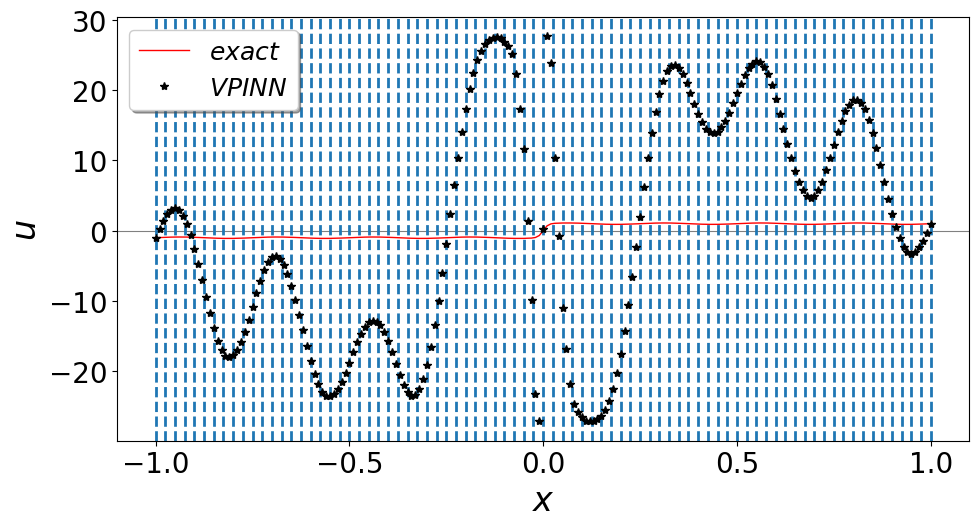

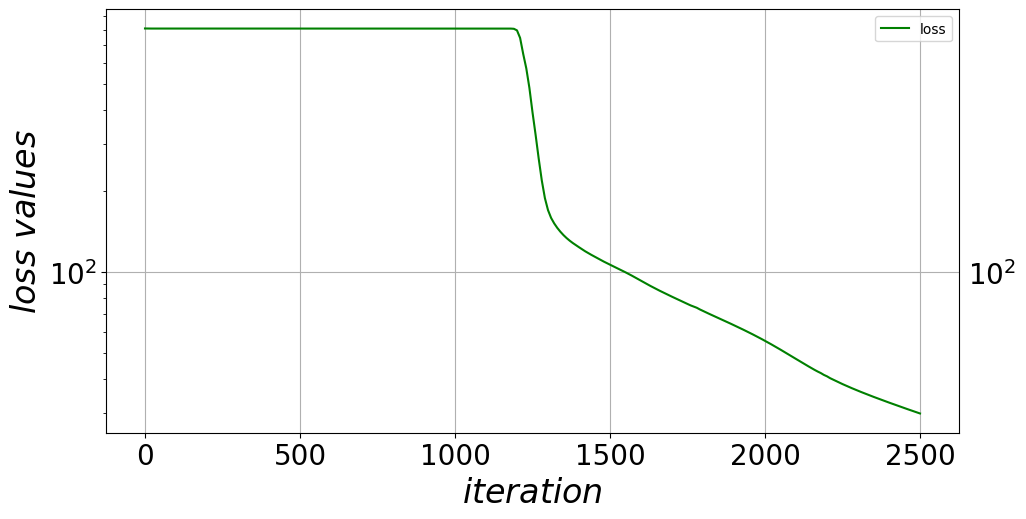

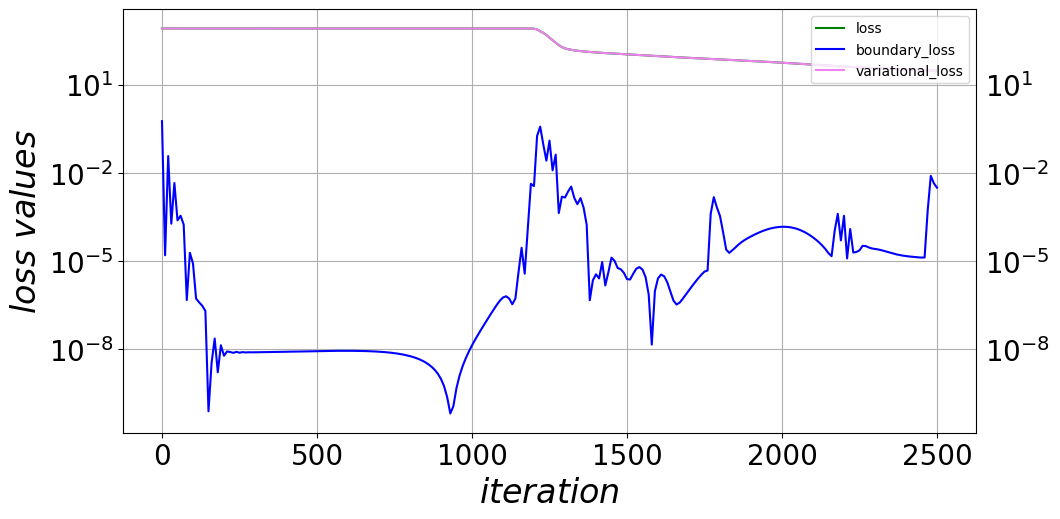

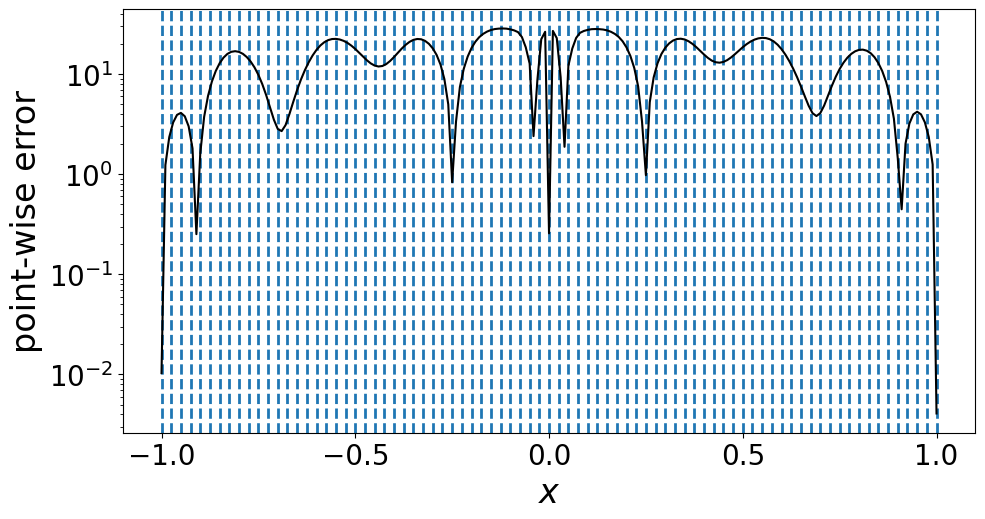

In [5]:
PLOT = 'show'

# incrasing number of elem

n=[5,10,20,40,80]

for elem in n:

    params['n_elements']=elem
    params['n_test']=params['n_elements']*[N_tests]
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

    model = VPINN(pb,params,42,None)
    print("Number of elements : ",elem)
    model.plot_predict(PLOT)

    loss_his = model.train(params['Opt_Niter'])

    model.plot_predict(PLOT)
    model.plot_loss_history(PLOT)    
    model.plot_pointwise_error(PLOT)


In [6]:
print(model.NN.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 20)                40        
                                                                 
 dense_21 (Dense)            (None, 20)                420       
                                                                 
 dense_22 (Dense)            (None, 20)                420       
                                                                 
 dense_23 (Dense)            (None, 20)                420       
                                                                 
 dense_24 (Dense)            (None, 1)                 21        
                                                                 
Total params: 1321 (10.32 KB)
Trainable params: 1321 (10.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [7]:
print(params['NN_struct'][0])
input=tf.constant([[1.0],[2.0]],dtype=tf.float64)
print(input)

#the input must be a tensor of two dims(col)
#if you inherit from tf.keras model and you init like you did you can view the structure of the the net if you type:
print(model.NN(input))


1
tf.Tensor(
[[1.]
 [2.]], shape=(2, 1), dtype=float64)
tf.Tensor(
[[  1.00407687]
 [-14.74744723]], shape=(2, 1), dtype=float64)
